In [9]:
#imports
import requests
import json
import pandas as pd
import numpy as np
import warnings
import random
import matplotlib.pyplot as plt
from datetime import datetime
import time as clock

start_time = clock.time()
# Sensors_Data = pd.read_json('data/W512_readings.json')
# Aircon_Data = pd.read_json('data/W512_aircon_status.json')
# Weather_Data = pd.read_json('data/Weather_data.json')

Sensors_Data = pd.read_json('../test/W512_readings1.json')
Aircon_Data = pd.read_json('../test/W512_aircon_status1.json')
Weather_Data = pd.read_json('../test/Weather_data1.json')
# Aircon_Data = Aircon_Data.iloc[3194:] #testing out new dataset (data is cleaned before pulling)
# Normalize the data
Aircon_rows = []

for _, row in Aircon_Data.iterrows():
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    fc_readings = row['FC_FullStatus_Readings']
    if fc_readings and isinstance(fc_readings, dict):
        for unit, data in fc_readings.items():
            if any(data.get("Set_Point", None) == 404.0 for data in fc_readings.values()):
                continue
            flattened_row[f"{unit}_Status"] = data.get("Status", None)
            flattened_row[f"{unit}_Fan_Status"] = data.get("Fan_Status", None)
            flattened_row[f"{unit}_Set_Point"] = data.get("Set_Point", None)
            flattened_row[f"{unit}_Operation_Mode"] = data.get("Operation_Mode", None)
    
    Aircon_rows.append(flattened_row)

Sensors_rows = []
include_keys_1 = ["24E124725E285123", "24E124725E331695","24E124725E331744",
                      "24E124725E332483","24E124725E290348","24E124725E331733","24E124725E286745","24E124725E332564" # "24E124136D316361" is supposed to be outdoor but it is not outdoor yet
                         "24E124757E150866","24E124757E150896"]

include_keys_2 = ["Sensor_1","Sensor_3","Sensor_6"]
for _, row in Sensors_Data.iterrows():
    invalid_input = False
    
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    
    lorawan_readings = row['Lorawan_Readings']
    
    if isinstance(lorawan_readings, dict):
        for unit, data in lorawan_readings.items():
            if unit not in include_keys_1:
                continue
            if isinstance(data, dict):  # Ensure that each item in Lorawan_Readings is a dictionary
                for key, value in data.items():
                    
                    flattened_row[f"{unit}_{key}"] = value
            
    energy_readings = row['Energy_Readings']
    total_power = 0
    total_energy = 0
    invalid_input_power = False
    invalid_input_energy = False
    
    if energy_readings and isinstance(energy_readings, dict):
        for unit, data in energy_readings.items():
            if unit not in include_keys_2:
                continue
            power = data.get('Power', None)
            energy = data.get('Energy', None)
            if power is None:
                invalid_input_power = True
            if energy is None:
                invalid_input_energy = True
            total_power += power
            total_energy += energy
        
    if invalid_input_power:
        total_power = None
    if invalid_input_energy:
        total_energy = None
        
    flattened_row["Total_Energy"] = total_energy
    flattened_row["Total_Power"] = total_power
    
    Sensors_rows.append(flattened_row)


# Normalize the data
Weather_rows = []

for _, row in Weather_Data.iterrows():
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    flattened_row['weather_status']= row['result']['weather_status']
    flattened_row['weather_temp']= row['result']['weather_temp']
    flattened_row['weather_humidity']= row['result']['weather_humidity']
    
    Weather_rows.append(flattened_row)



Aircon_Normalize_Data = pd.DataFrame(Aircon_rows)
Sensors_Normalize_Data = pd.DataFrame(Sensors_rows)
Weather_Normalize_Data = pd.DataFrame(Weather_rows)
# For Aircon_Normalize_Data
Aircon_Normalize_Data['datetime_str'] = Aircon_Normalize_Data['date'].astype(str) + ' ' + Aircon_Normalize_Data['time']
Aircon_Normalize_Data['datetime'] = Aircon_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Aircon_Normalize_Data['timestamp'] = Aircon_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

# For Sensors_Normalize_Data
Sensors_Normalize_Data['datetime_str'] = Sensors_Normalize_Data['date'].astype(str) + ' ' + Sensors_Normalize_Data['time']
Sensors_Normalize_Data['datetime'] = Sensors_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Sensors_Normalize_Data['timestamp'] = Sensors_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

# For Weather_Normalize_Data
Weather_Normalize_Data['datetime_str'] = Weather_Normalize_Data['date'].astype(str) + ' ' + Weather_Normalize_Data['time']
Weather_Normalize_Data['datetime'] = Weather_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Weather_Normalize_Data['timestamp'] = Weather_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

merged_data = pd.merge_asof(
    Aircon_Normalize_Data,  # Left DataFrame
    Sensors_Normalize_Data,      # Right DataFrame
    on='timestamp',   # Key column
    direction='nearest'    # Match the nearest time
)
merged_data = pd.merge_asof(
    merged_data,  # Left DataFrame
    Weather_Normalize_Data,      # Right DataFrame
    on='timestamp',   # Key column
    direction='nearest'    # Match the nearest time
)

temperature_col = [
    col for col in merged_data.columns 
    if "temperature" in col.lower()
]
humidity_col = [
    col for col in merged_data.columns 
    if "humidity" in col.lower()
]
c02_col = [
    col for col in merged_data.columns
    if "co2" in col.lower()
]

occupancy_col_total_in = [
    col for col in merged_data.columns
    if "total_in" in col.lower()
]

occupancy_col_total_out = [
    col for col in merged_data.columns
    if "total_out" in col.lower()
]

def get_unit_columns(unit_number, columns):
    return [col for col in columns if f"FC_Unit_{unit_number}" in col]

aircon_units = len([
    col for col in merged_data.columns
    if "FC_Unit_" in col and "_Status" in col and "Fan" not in col
])

aircon_units_cols = {}

for unit in range(1, aircon_units + 1):
    aircon_units_cols[f'Unit_{unit}'] = get_unit_columns(unit, merged_data.columns)


final_data = pd.DataFrame()
final_data["timestamp"] = merged_data["timestamp"]

final_data["temperature"] = merged_data[temperature_col].apply(lambda x: round(x.mean(), 3), axis=1)
final_data["humidity"] = merged_data[humidity_col].apply(lambda x: round(x.mean(),3), axis=1)
final_data["co2"] = merged_data[c02_col].apply(lambda x: round(x.mean(),3), axis=1)

final_data['power_consumption'] = merged_data['Total_Power']
final_data['energy_consumption'] = merged_data['Total_Energy']

final_data["weather_status"] = merged_data["weather_status"]
final_data["weather_temp"] = merged_data['weather_temp']
final_data["weather_humid"] = merged_data['weather_humidity']


merged_data[occupancy_col_total_in] = merged_data[occupancy_col_total_in].fillna(method='bfill')
merged_data[occupancy_col_total_out] = merged_data[occupancy_col_total_out].fillna(method='bfill')

final_data['occupancy'] = (
    merged_data[occupancy_col_total_in].sum(axis=1) - merged_data[occupancy_col_total_out].sum(axis=1)
)


for unit, columns in aircon_units_cols.items():
    for column in columns:
        if 'set_point' in column:
            final_data[column] = merged_data[column].replace(0, pd.NA).ffill()
        else:
            final_data[column] = merged_data[column].replace("ERROR", pd.NA).ffill()

final_data.dropna(inplace=True)
print("final_data_created")

# Sorting the data by energy_consumption in ascending order
final_data = final_data.sort_values(by="timestamp", ascending=True)
final_data.to_csv("test.csv", index=False)

def getFCData(data, row_index):
    settings = []
    for i in range(1, aircon_units + 1):
        settings.append(data[f"FC_Unit_{i}_Status"].iloc[row_index])
        settings.append(data[f"FC_Unit_{i}_Fan_Status"].iloc[row_index])
        settings.append(data[f"FC_Unit_{i}_Set_Point"].iloc[row_index])
        settings.append(data[f"FC_Unit_{i}_Operation_Mode"].iloc[row_index])
        
    return settings

def is_same_settings(data, curr_row_index, next_row_index):   
    return True if (getFCData(data, curr_row_index) == getFCData(data, next_row_index)) else False


def is_all_off(data, curr_row_index, check_for_off):
    for i in range(1, aircon_units + 1):
        if data[f"FC_Unit_{i}_Status"].iloc[curr_row_index] == "ON":
            return not check_for_off
        
    return check_for_off

def is_within_time_range(data, curr_row_index, next_row_index):
    if data["timestamp"].iloc[next_row_index] - data["timestamp"].iloc[curr_row_index] < 3600:
        return True
    else:
        return False


aircon_status_result = pd.DataFrame()
total_final_rows = final_data.shape[0]
Aircon_Normalize_Data = Aircon_Normalize_Data.drop(['date', 'time', 'datetime_str', 'datetime', 'timestamp'], axis=1)

for i in range(total_final_rows - 1):
    if is_all_off(final_data, i ,True):
        continue
    
    curr_timestamp = final_data["timestamp"].iloc[i]
    
    curr_energy = final_data["energy_consumption"].iloc[i]
    next_energy = final_data["energy_consumption"].iloc[i + 1]
    
    curr_temperature = final_data["temperature"].iloc[i]
    curr_humidity = final_data["humidity"].iloc[i]

    curr_weather_status = final_data["weather_status"].iloc[i]
    curr_weather_temp = final_data["weather_temp"].iloc[i]
    curr_weather_humid = final_data["weather_humid"].iloc[i]
    

    if is_same_settings(final_data, i , i + 1) and is_within_time_range(final_data, i , i + 1):   
        if next_energy - curr_energy > 50: # there is a outlier then has more than 70kwh differnce within a 1 hour period (error from data collection)
            continue
            
        if next_energy - curr_energy < 0:
            diff = 0
        else:
            diff = next_energy - curr_energy
        
    temp_df = pd.DataFrame({
        'timestamp': [curr_timestamp],
        'energy_consumption': [diff],
        'temperature': [curr_temperature],
        'humidity': [curr_humidity],
        'weather_status': [curr_weather_status],
        'weather_temp': [curr_weather_temp],
        'weather_humid': [curr_weather_humid]
    })
    for col in Aircon_Normalize_Data.columns:
        temp_df[col] = final_data[col].iloc[i]

    aircon_status_result = pd.concat([aircon_status_result, temp_df], ignore_index=False)


# Optionally, you can save the updated dataframe
aircon_status_result.to_csv("updated_test.csv", index=False)




C:\Users\Ang Yun Yang\AppData\Local\Temp\ipykernel_25792\2738341969.py:207: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[occupancy_col_total_in] = merged_data[occupancy_col_total_in].fillna(method='bfill')
C:\Users\Ang Yun Yang\AppData\Local\Temp\ipykernel_25792\2738341969.py:208: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[occupancy_col_total_out] = merged_data[occupancy_col_total_out].fillna(method='bfill')


final_data_created


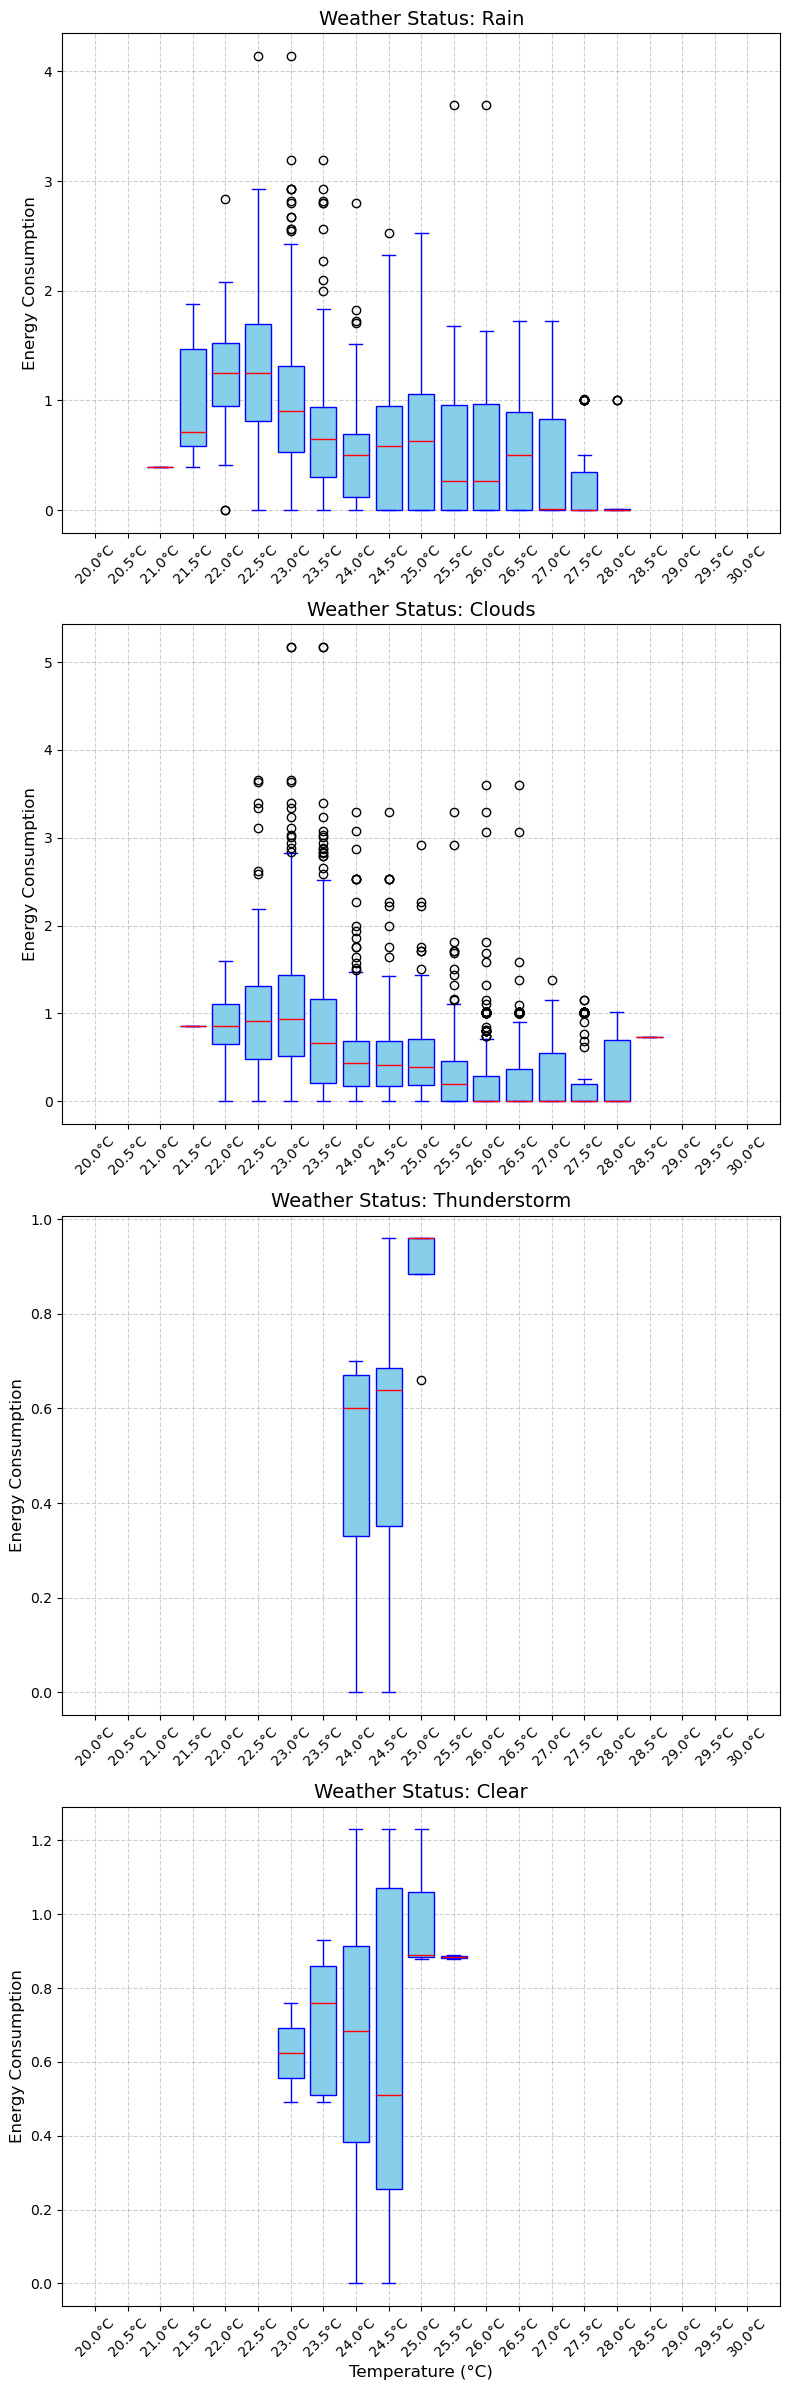

In [35]:
import matplotlib.pyplot as plt
import numpy as np

max_energy_consumption = 50  # Adjust this value based on your data

# Define unique weather statuses and temperature range
unique_weather_statuses = aircon_status_result["weather_status"].unique()
temperature_values = np.around(np.arange(20, 30.5, 0.5), decimals=1)

# Initialize a figure with subplots for each weather status
num_statuses = len(unique_weather_statuses)
fig, axes = plt.subplots(num_statuses, 1, figsize=(8, 6 * num_statuses), sharex=False)

# Ensure axes is iterable in case of single weather status
if num_statuses == 1:
    axes = [axes]

# Loop through unique weather statuses and their corresponding axes
for i, (status, ax) in enumerate(zip(unique_weather_statuses, axes)):
    if status == "HAZE":
        continue
    weather_data = aircon_status_result[aircon_status_result["weather_status"] == status]

    # Prepare a list to store energy consumption data for each temperature bin
    energy_consumption_data = []

    # Loop through temperature values
    for temp in temperature_values:
        # Filter data for current temperature bin
        temp_data = weather_data[
            (weather_data['temperature'] >= (temp - 0.5)) & 
            (weather_data['temperature'] <= (temp + 0.5))
        ]
        temp_data = temp_data[temp_data["energy_consumption"] < max_energy_consumption]
        
        # Append energy consumption values for the bin
        energy_consumption_data.append(temp_data['energy_consumption'].values)

    # Create a box plot for the current weather status
    ax.boxplot(
        energy_consumption_data, 
        positions=temperature_values, 
        widths=0.4, 
        patch_artist=True,
        boxprops=dict(facecolor='skyblue', color='blue'),
        medianprops=dict(color='red'),
        whiskerprops=dict(color='blue'),
        capprops=dict(color='blue')
    )

    # Set the title and labels for the current subplot
    ax.set_title(f"Weather Status: {status}", fontsize=14)
    ax.set_ylabel('Energy Consumption', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    ax.set_xticks(temperature_values)
    ax.set_xticklabels([f"{temp}°C" for temp in temperature_values], rotation=45, fontsize=10)


# Set the shared x-label for the entire figure
axes[-1].set_xlabel('Temperature (°C)', fontsize=12)

plt.subplots_adjust(hspace=0.4)  # Reduce vertical spacing

plt.tight_layout()
plt.show()


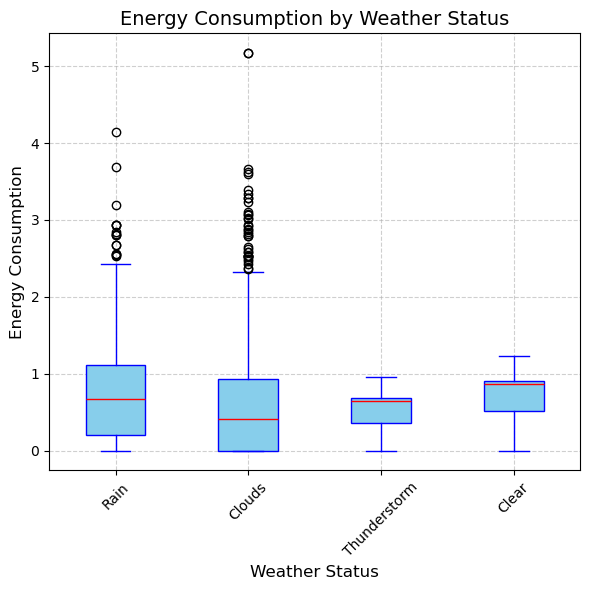

In [40]:
import matplotlib.pyplot as plt
import numpy as np

max_energy_consumption = 50  # Adjust this value based on your data

# Define unique weather statuses, excluding "Haze"
unique_weather_statuses = aircon_status_result["weather_status"].unique()
# Initialize data for box plots
boxplot_data = []

# Collect energy consumption data for each weather status
for status in unique_weather_statuses:
    weather_data = aircon_status_result[
        (aircon_status_result["weather_status"] == status)
    ]
    # Filter data to exclude values above max consumption
    valid_data = weather_data[weather_data["energy_consumption"] < max_energy_consumption]
    boxplot_data.append(valid_data["energy_consumption"])

# Create a box plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot(
    boxplot_data,
    labels=unique_weather_statuses,
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='blue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
)

# Add labels and title
ax.set_title("Energy Consumption by Weather Status", fontsize=14)
ax.set_ylabel("Energy Consumption", fontsize=12)
ax.set_xlabel("Weather Status", fontsize=12)

# Customize x-axis labels
ax.set_xticks(range(1, len(unique_weather_statuses) + 1))
ax.set_xticklabels(unique_weather_statuses, rotation=45, fontsize=10)

# Add grid for better readability
ax.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


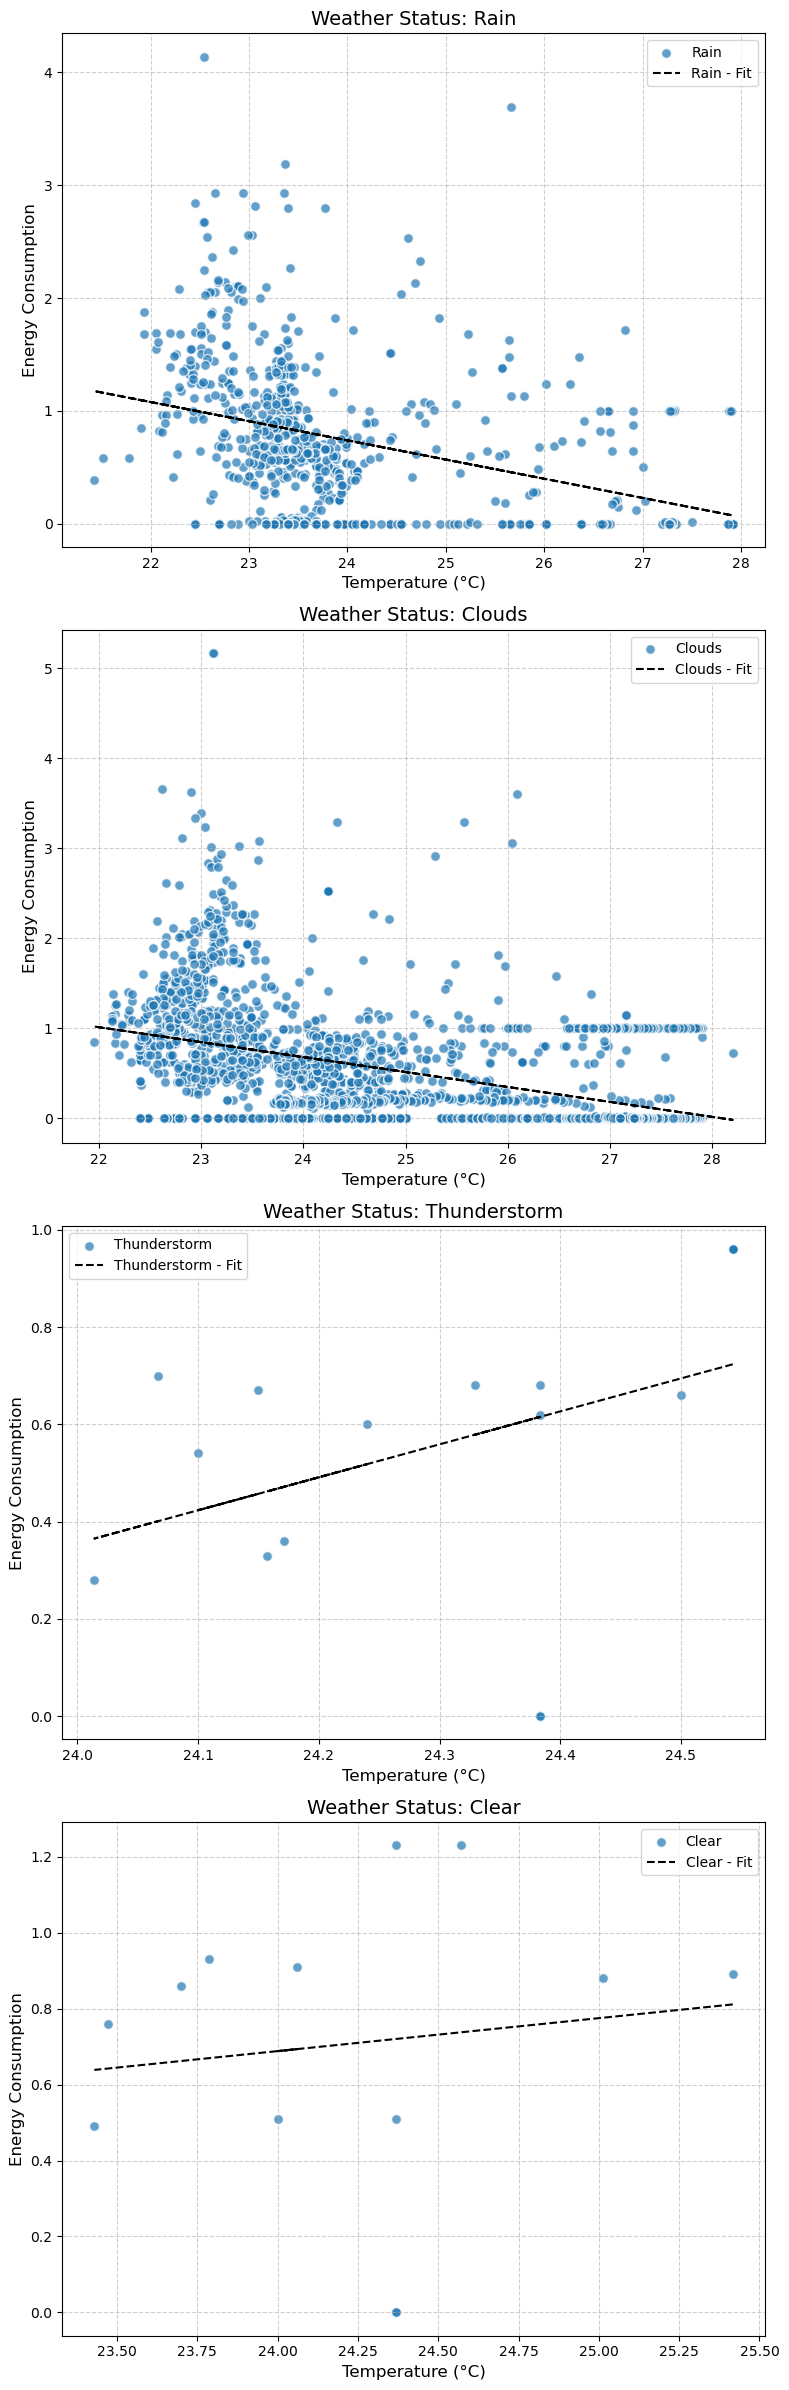

In [48]:
import matplotlib.pyplot as plt
import numpy as np

max_energy_consumption = 50  # Adjust this value based on your data

# Define unique weather statuses
unique_weather_statuses = aircon_status_result["weather_status"].unique()

# Initialize a figure with subplots for each weather status
num_statuses = len(unique_weather_statuses)
fig, axes = plt.subplots(num_statuses, 1, figsize=(8, 6 * num_statuses), sharex=False)

# Ensure axes is iterable in case of single weather status
if num_statuses == 1:
    axes = [axes]

# Loop through unique weather statuses and their corresponding axes
for i, status in enumerate(unique_weather_statuses):
    weather_data = aircon_status_result[aircon_status_result["weather_status"] == status]

    # Filter the data based on temperature and energy consumption
    weather_data_filtered = weather_data[weather_data["energy_consumption"] < max_energy_consumption]

    # Scatter plot for the current weather status
    axes[i].scatter(
        weather_data_filtered["temperature"],  # x: temperature
        weather_data_filtered["energy_consumption"],  # y: energy consumption
        label=status,  # Label for the current weather status
        alpha=0.7,
        edgecolors='w',  # White border around the points
        s=50  # Marker size
    )
    
    # Best fit line (linear regression)
    # Fit a linear model to the data (degree 1)
    p = np.polyfit(weather_data_filtered["temperature"], weather_data_filtered["energy_consumption"], 1)
    # Create a polynomial function based on the fit
    fit_line = np.poly1d(p)
    # Plot the best fit line
    axes[i].plot(
        weather_data_filtered["temperature"], 
        fit_line(weather_data_filtered["temperature"]), 
        label=f'{status} - Fit', linestyle='--', color='black'
    )

    # Set the title and labels for the current subplot
    axes[i].set_title(f"Weather Status: {status}", fontsize=14)
    axes[i].set_xlabel('Temperature (°C)', fontsize=12)
    axes[i].set_ylabel('Energy Consumption', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.6)
    axes[i].legend(fontsize=10)

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()


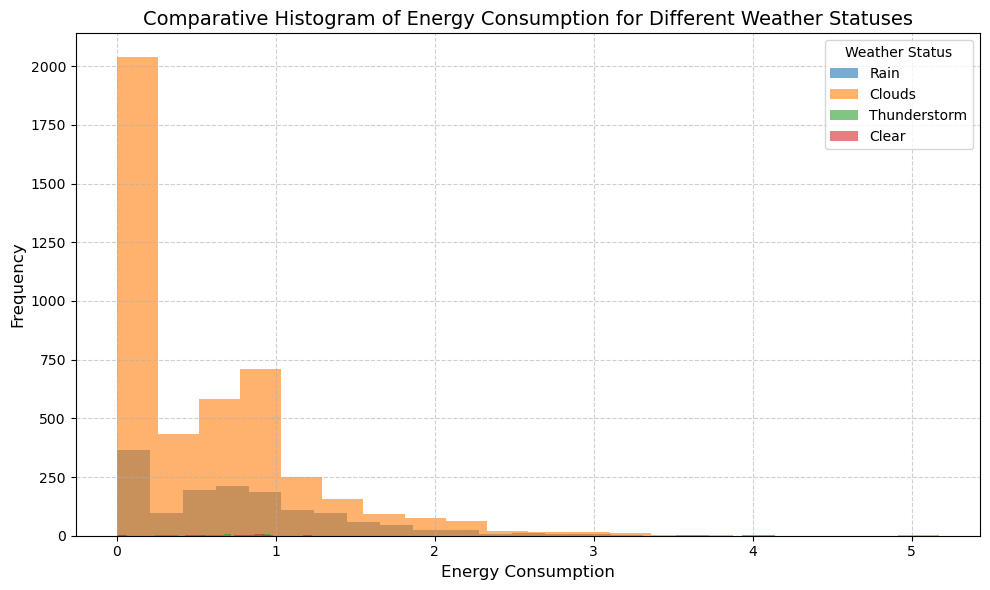

In [49]:
import matplotlib.pyplot as plt
import numpy as np

max_energy_consumption = 50  # Adjust this value based on your data

# Define unique weather statuses and temperature range
unique_weather_statuses = aircon_status_result["weather_status"].unique()
temperature_values = np.around(np.arange(20, 30.5, 0.5), decimals=1)

# Initialize a figure for the comparative histogram
plt.figure(figsize=(10, 6))

# Loop through unique weather statuses and prepare energy consumption data
for status in unique_weather_statuses:
    if status == "HAZE":
        continue
    
    weather_data = aircon_status_result[aircon_status_result["weather_status"] == status]
    
    # Prepare a list to store energy consumption data for each temperature bin
    energy_consumption_data = []

    # Loop through temperature values
    for temp in temperature_values:
        # Filter data for current temperature bin
        temp_data = weather_data[
            (weather_data['temperature'] >= (temp - 0.5)) & 
            (weather_data['temperature'] <= (temp + 0.5))
        ]
        temp_data = temp_data[temp_data["energy_consumption"] < max_energy_consumption]
        
        # Append energy consumption values for the bin
        energy_consumption_data.extend(temp_data['energy_consumption'].values)

    # Plot histogram for the current weather status
    plt.hist(
        energy_consumption_data, 
        bins=20,  # Adjust the number of bins as needed
        alpha=0.6, 
        label=status, 
        histtype='stepfilled', 
        linewidth=2
    )

# Set titles and labels
plt.title('Comparative Histogram of Energy Consumption for Different Weather Statuses', fontsize=14)
plt.xlabel('Energy Consumption', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Weather Status', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


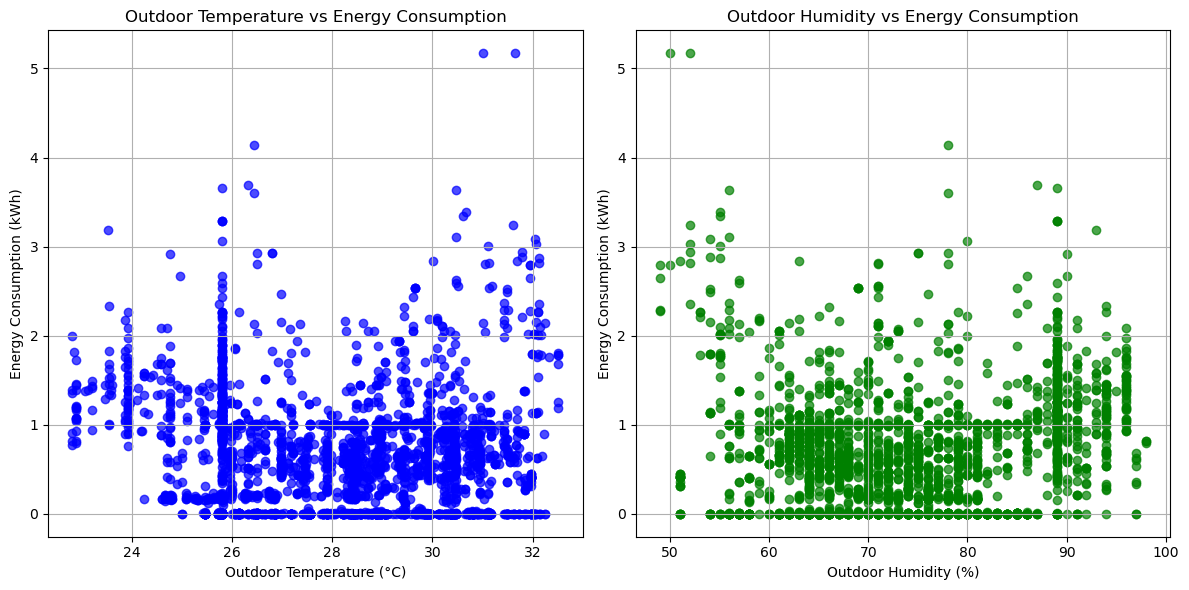

In [14]:
import matplotlib.pyplot as plt
import numpy as np

outdoor_temp = aircon_status_result["weather_temp"]
energy = aircon_status_result["energy_consumption"]

outdoor_humi = aircon_status_result["weather_humid"]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot: Temperature vs Energy
axs[0].scatter(outdoor_temp, energy, color='blue', alpha=0.7)
axs[0].set_title('Outdoor Temperature vs Energy Consumption')
axs[0].set_xlabel('Outdoor Temperature (°C)')
axs[0].set_ylabel('Energy Consumption (kWh)')
axs[0].grid(True)

# Second subplot: Humidity vs Energy
axs[1].scatter(outdoor_humi, energy, color='green', alpha=0.7)
axs[1].set_title('Outdoor Humidity vs Energy Consumption')
axs[1].set_xlabel('Outdoor Humidity (%)')
axs[1].set_ylabel('Energy Consumption (kWh)')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()